Using device: cpu
Original train shape: (1460, 81)
Original test shape: (1459, 80)
Combined shape after FE, before other processing: (2919, 91)
Final processed train shape: (1460, 251)
Final processed test shape: (1459, 251)

X_train shape (before scaling): (1168, 251)
Using ReduceLROnPlateau scheduler.

Starting training...
Epoch 1/2000, Train Loss: 109.150518, Val Loss: 83.106106, Train R²: -733.3561, Val R²: -444.3441
Val loss decreased (83.106106). Saving model to best_house_price_model.pth
Epoch 2/2000, Train Loss: 44.508803, Val Loss: 22.860598, Train R²: -289.4829, Val R²: -121.5040
Val loss decreased (22.860598). Saving model to best_house_price_model.pth
Epoch 3/2000, Train Loss: 8.507926, Val Loss: 2.040989, Train R²: -54.8637, Val R²: -9.9371
Val loss decreased (2.040989). Saving model to best_house_price_model.pth
Epoch 4/2000, Train Loss: 3.165728, Val Loss: 0.477616, Train R²: -19.8049, Val R²: -1.5594
Val loss decreased (0.477616). Saving model to best_house_price_model.

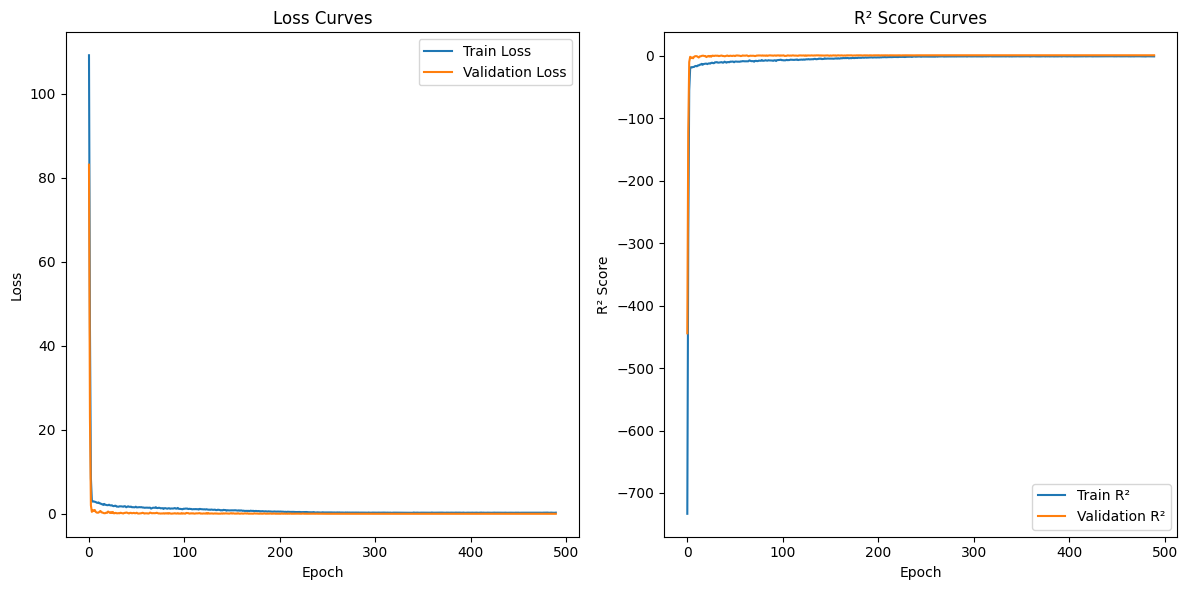


              Metryki końcowe (na oryginalnej skali cen)              
Zbiór           | MSE             | RMSE            | R²         | RMSLE     
----------------------------------------------------------------------
Treningowy      | 495674773.73    | 22263.75        | 0.9169     | 0.0948    
Walidacyjny     | 1115741963.86   | 33402.72        | 0.8545     | 0.1408    



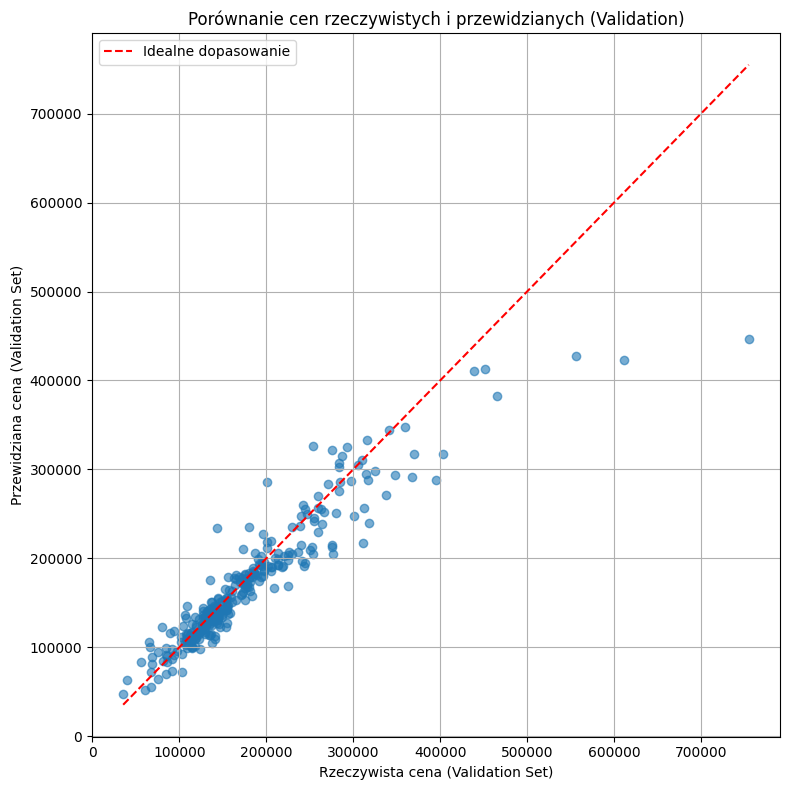

Zapisano przewidywania (1459 wierszy) do pliku submission_final.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# ==============================================
# KONFIGURACJA MODELU
# ==============================================
config = {
    "batch_size": 32,
    "learning_rate": 0.003,
    "epochs": 2000,
    "early_stopping_patience": 100,
    "hidden_layers": [512, 256, 128, 64],
    "dropout_rate": 0.3,
    "use_dropout": True,
    "validation_size": 0.2,
    "random_state": 42,
    "target_transform": True, 
    "weight_decay": 1e-4,
    "use_scheduler": True,
    "scheduler_patience": 25,
    "scheduler_factor": 0.3,
    "min_lr": 1e-7,
    "model_save_path": "best_house_price_model.pth", 
    "submission_file_name": "submission_final.csv" 
}

# ==============================================
# WCZYTYWANIE DANYCH
# ==============================================
def load_data(train_path="Data/train.csv", test_path="Data/test.csv"):
    try:
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        print(f"Original train shape: {train_df.shape}")
        print(f"Original test shape: {test_df.shape}")
        if train_df.empty or test_df.empty:
            raise ValueError("Loaded train_df or test_df is empty!")
        return train_df, test_df
    except FileNotFoundError:
        print(f"FATAL: {train_path} or {test_path} not found.")
        raise SystemExit("Exiting due to missing data files.")

# ==============================================
# PRZETWARZANIE DANYCH I FEATURE ENGINEERING
# ==============================================
def preprocess_data(train_df, test_df, target_transform=True):
    test_ids = test_df['Id']
    
    train_index = train_df.index
    test_index = test_df.index
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    
    all_features_df = pd.concat((train_df, test_df), ignore_index=True).copy()

    # --- Feature Engineering ---
    all_features_df['HouseAge'] = all_features_df['YrSold'] - all_features_df['YearBuilt']
    all_features_df['RemodAge'] = all_features_df['YrSold'] - all_features_df['YearRemodAdd']
    all_features_df['IsRemodeled'] = (all_features_df['YearRemodAdd'] != all_features_df['YearBuilt']).astype(int)
    all_features_df.loc[all_features_df['YearRemodAdd'] == all_features_df['YearBuilt'], 'RemodAge'] = all_features_df['HouseAge']

    base_sf_cols = ['GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 
                    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    for col in base_sf_cols:
        if col not in all_features_df.columns: all_features_df[col] = 0
        all_features_df[col] = all_features_df[col].fillna(0)

    all_features_df['TotalSF'] = all_features_df['GrLivArea'] + all_features_df['TotalBsmtSF']
    all_features_df['TotalFinishedSF'] = all_features_df['GrLivArea'] + all_features_df['BsmtFinSF1'] + all_features_df['BsmtFinSF2']
    all_features_df['TotalPorchSF'] = all_features_df['OpenPorchSF'] + all_features_df['EnclosedPorch'] + \
                                   all_features_df['3SsnPorch'] + all_features_df['ScreenPorch']

    bath_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
    for col in bath_cols:
        if col not in all_features_df.columns: all_features_df[col] = 0
        all_features_df[col] = all_features_df[col].fillna(0)
    all_features_df['TotalBath'] = all_features_df['FullBath'] + 0.5 * all_features_df['HalfBath'] + \
                                all_features_df['BsmtFullBath'] + 0.5 * all_features_df['BsmtHalfBath']

    all_features_df['HasPool'] = (all_features_df.get('PoolArea', pd.Series(0, index=all_features_df.index)).fillna(0) > 0).astype(int)
    all_features_df['HasFireplace'] = (all_features_df.get('Fireplaces', pd.Series(0, index=all_features_df.index)).fillna(0) > 0).astype(int)
    all_features_df['HasGarage'] = (all_features_df.get('GarageArea', pd.Series(0, index=all_features_df.index)).fillna(0) > 0).astype(int)
    
    all_features_df['BsmtFinToTotalBsmt_Ratio'] = (all_features_df['BsmtFinSF1'] + all_features_df['BsmtFinSF2']) / (all_features_df['TotalBsmtSF'] + 1e-6)
    all_features_df['LotArea_x_GrLivArea_Ratio'] = all_features_df['GrLivArea'] / (all_features_df['LotArea'] + 1e-6)

    train_df_fe = all_features_df[all_features_df['is_train'] == 1].drop(columns=['is_train'])
    test_df_fe = all_features_df[all_features_df['is_train'] == 0].drop(columns=['is_train', 'SalePrice'])
    train_df_fe.index = train_index
    test_df_fe.index = test_index
    train_df = train_df_fe
    test_df = test_df_fe

    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    if target_transform and 'SalePrice' in train_df.columns:
        train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

    y_train_full = None
    split_point = 0
    if 'SalePrice' in train_df.columns:
        y_train_full = train_df['SalePrice'].copy()
        train_df_features = train_df.drop(['SalePrice'], axis=1)
        all_df = pd.concat((train_df_features.reset_index(drop=True), 
                            test_df.reset_index(drop=True)), 
                           ignore_index=True)
        split_point = len(train_df_features)
    else:
        all_df = pd.concat((train_df.reset_index(drop=True), 
                            test_df.reset_index(drop=True)), 
                           ignore_index=True)
        split_point = len(train_df)
        
    print(f"Combined shape after FE, before other processing: {all_df.shape}")

    # --- Standard Preprocessing ---
    if 'LotFrontage' in all_df.columns and 'Neighborhood' in all_df.columns:
        all_df['LotFrontage'] = all_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        all_df['LotFrontage'] = all_df['LotFrontage'].fillna(all_df['LotFrontage'].median())
    elif 'LotFrontage' in all_df.columns:
        all_df['LotFrontage'] = all_df['LotFrontage'].fillna(all_df['LotFrontage'].median())

    cols_fillna_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                        'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                        'PoolQC', 'Fence', 'MasVnrType', 'MiscFeature']
    for col in cols_fillna_none:
        if col in all_df.columns: all_df[col] = all_df[col].fillna('None')

    num_cols_with_na = all_df.select_dtypes(include=np.number).isnull().sum()
    num_cols_to_fill = num_cols_with_na[num_cols_with_na > 0].index
    if len(num_cols_to_fill) > 0:
        for col in num_cols_to_fill: all_df[col] = all_df[col].fillna(all_df[col].median())

    cat_cols_with_na = all_df.select_dtypes(include='object').isnull().sum()
    cat_cols_to_fill = cat_cols_with_na[cat_cols_with_na > 0].index
    if len(cat_cols_to_fill) > 0:
        for col in cat_cols_to_fill: all_df[col] = all_df[col].fillna(all_df[col].mode()[0])
    
    if all_df.isnull().sum().sum() > 0:
        print(f"Warning: NaNs still present after imputation ({all_df.isnull().sum().sum()} total). Filling with 0.")
        all_df = all_df.fillna(0)

    ordinal_mappings = {
        'ExterQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'ExterCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
        'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'HeatingQC': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'KitchenQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'PoolQC': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, 'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
        'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}, 'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
        'PavedDrive': {'N': 0, 'P': 1, 'Y': 2}, 'Street': {'Grvl': 0, 'Pave': 1},
        'Alley': {'None': 0, 'Grvl': 1, 'Pave': 2}, 'CentralAir': {'N': 0, 'Y': 1},
        'Utilities': {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
        'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
        'Functional': {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
    }
    for col, mapping in ordinal_mappings.items():
        if col in all_df.columns: all_df[col] = all_df[col].map(mapping).fillna(0)
            
    if 'OverallQual' in all_df.columns and 'OverallCond' in all_df.columns:
        all_df['OverallGrade'] = all_df['OverallQual'] * all_df['OverallCond']
    if 'GarageQual' in all_df.columns and 'GarageCond' in all_df.columns:
        all_df['GarageGrade'] = all_df['GarageQual'] * all_df['GarageCond']
    if 'ExterQual' in all_df.columns and 'ExterCond' in all_df.columns:
        all_df['ExterGrade'] = all_df['ExterQual'] * all_df['ExterCond']

    if 'MSSubClass' in all_df.columns: all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

    categorical_cols = [col for col in all_df.columns if all_df[col].dtype == 'object']
    if 'MSSubClass' in all_df.columns and isinstance(all_df['MSSubClass'].dtype, pd.StringDtype):
        if 'MSSubClass' not in categorical_cols: categorical_cols.append('MSSubClass')
    elif 'MSSubClass' in all_df.columns and all_df['MSSubClass'].dtype == 'object':
         if 'MSSubClass' not in categorical_cols: categorical_cols.append('MSSubClass')
    
    if categorical_cols:
        all_df = pd.get_dummies(all_df, columns=categorical_cols, dummy_na=False, dtype=int)

    train_processed = all_df.iloc[:split_point]
    test_processed = all_df.iloc[split_point:]
    
    print(f"Final processed train shape: {train_processed.shape}")
    print(f"Final processed test shape: {test_processed.shape}")

    if y_train_full is not None:
        train_processed = train_processed.copy() 
        train_processed.loc[:, 'SalePrice'] = y_train_full.values

    return train_processed, test_processed, test_ids

# ==============================================
# MODEL SIECI NEURONOWEJ
# ==============================================
class HousePriceModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate=0.2, use_dropout=True):
        super(HousePriceModel, self).__init__()
        layers = []
        prev_layer_size = input_dim
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            if use_dropout: layers.append(nn.Dropout(dropout_rate))
            prev_layer_size = layer_size
        layers.append(nn.Linear(prev_layer_size, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ==============================================
# TRENING MODELU
# ==============================================
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, patience, device, model_save_path, scheduler=None):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses, train_r2_hist, val_r2_hist = [], [], [], []

    if not train_loader or len(train_loader) == 0:
        print("FATAL: train_loader is effectively empty. Cannot train.")
        return model, train_losses, val_losses, train_r2_hist, val_r2_hist

    for epoch in range(epochs):
        model.train()
        running_loss, num_train_samples_processed = 0.0, 0
        all_preds_train_epoch, all_true_train_epoch = [], []
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"FATAL: NaN/Inf training loss at epoch {epoch+1}. Stopping.")
                return model, train_losses, val_losses, train_r2_hist, val_r2_hist
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
            num_train_samples_processed += batch_X.size(0)
            all_preds_train_epoch.extend(outputs.cpu().detach().numpy())
            all_true_train_epoch.extend(batch_y.cpu().detach().numpy())
        
        epoch_train_loss, train_r2 = np.nan, np.nan
        if num_train_samples_processed > 0:
            epoch_train_loss = running_loss / num_train_samples_processed
            if len(all_true_train_epoch) >= 1:
                y_true_np_train = np.array(all_true_train_epoch)
                train_r2 = r2_score(all_true_train_epoch, all_preds_train_epoch) if not np.all(y_true_np_train == y_true_np_train[0]) else (0.0 if np.all(np.array(all_preds_train_epoch) == y_true_np_train[0]) else np.nan)
        train_losses.append(epoch_train_loss); train_r2_hist.append(train_r2)
        
        model.eval()
        val_run_loss, num_val_samples_processed = 0.0, 0
        all_preds_val_epoch, all_true_val_epoch = [], []
        epoch_val_loss, val_r2 = np.nan, np.nan

        if val_loader and len(val_loader) > 0:
            with torch.no_grad():
                for val_X, val_y in val_loader:
                    val_X, val_y = val_X.to(device), val_y.to(device)
                    val_outputs = model(val_X); v_loss = criterion(val_outputs, val_y)
                    if not (torch.isnan(v_loss) or torch.isinf(v_loss)):
                        val_run_loss += v_loss.item() * val_X.size(0); num_val_samples_processed += val_X.size(0)
                        all_preds_val_epoch.extend(val_outputs.cpu().detach().numpy()); all_true_val_epoch.extend(val_y.cpu().detach().numpy())
            if num_val_samples_processed > 0:
                epoch_val_loss = val_run_loss / num_val_samples_processed
                if len(all_true_val_epoch) >= 1:
                    y_true_np_val = np.array(all_true_val_epoch)
                    val_r2 = r2_score(all_true_val_epoch, all_preds_val_epoch) if not np.all(y_true_np_val == y_true_np_val[0]) else (0.0 if np.all(np.array(all_preds_val_epoch) == y_true_np_val[0]) else np.nan)
        val_losses.append(epoch_val_loss); val_r2_hist.append(val_r2)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")
        
        if scheduler and num_val_samples_processed > 0 and not (np.isnan(epoch_val_loss) or np.isinf(epoch_val_loss)):
            old_lr = optimizer.param_groups[0]['lr']; scheduler.step(epoch_val_loss)
            if optimizer.param_groups[0]['lr'] < old_lr: print(f"Epoch {epoch+1}: LR reduced to {optimizer.param_groups[0]['lr']}")

        if num_val_samples_processed > 0 and not (np.isnan(epoch_val_loss) or np.isinf(epoch_val_loss)):
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss; epochs_no_improve = 0
                torch.save(model.state_dict(), model_save_path)
                print(f"Val loss decreased ({best_val_loss:.6f}). Saving model to {model_save_path}")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience: print(f"Early stopping at epoch {epoch+1}."); break
        elif epoch > patience and (not val_loader or len(val_loader)==0 or num_val_samples_processed == 0):
             print(f"Warning: No effective validation. Stopping early."); break
    
    if os.path.exists(model_save_path) and best_val_loss != float('inf') and not (np.isnan(best_val_loss) or np.isinf(best_val_loss)):
        print(f"Loading best model from {model_save_path}")
        model.load_state_dict(torch.load(model_save_path))
    else: print("Warning: Using model from last training epoch (best model not saved or invalid).")
    return model, train_losses, val_losses, train_r2_hist, val_r2_hist

# ==============================================
# OBLICZANIE METRYK
# ==============================================
def calculate_metrics(y_true, y_pred, context=""):
    y_true_flat, y_pred_flat = y_true.flatten(), y_pred.flatten()
    if len(y_true_flat) == 0 or len(y_pred_flat) == 0 or len(y_true_flat) != len(y_pred_flat):
        return np.nan, np.nan, np.nan, np.nan
    valid_indices = ~ (np.isnan(y_true_flat) | np.isinf(y_true_flat) | np.isnan(y_pred_flat) | np.isinf(y_pred_flat))
    y_true_clean, y_pred_clean = y_true_flat[valid_indices], y_pred_flat[valid_indices]
    if len(y_true_clean) == 0: return np.nan, np.nan, np.nan, np.nan

    r2 = np.nan
    if len(y_true_clean) >= 1 and not (np.var(y_true_clean) < 1e-9):
        try: r2 = r2_score(y_true_clean, y_pred_clean)
        except ValueError: pass 
    elif np.var(y_true_clean) < 1e-9 : 
         r2 = 0.0 if np.var(y_pred_clean) < 1e-9 and np.abs(np.mean(y_true_clean) - np.mean(y_pred_clean)) < 1e-9 else np.nan


    mse = mean_squared_error(y_true_clean, y_pred_clean); rmse = np.sqrt(mse)
    rmsle = np.nan
    y_true_rmsle, y_pred_rmsle = y_true_clean.copy(), y_pred_clean.copy()
    if np.any(y_pred_rmsle < 0): y_pred_rmsle[y_pred_rmsle < 0] = 0
    if not np.any(y_true_rmsle < 0) and len(y_true_rmsle) > 0:
        try:
            log_y_true, log_y_pred = np.log1p(y_true_rmsle), np.log1p(y_pred_rmsle)
            if not (np.any(np.isinf(log_y_true)) or np.any(np.isinf(log_y_pred)) or \
                    np.any(np.isnan(log_y_true)) or np.any(np.isnan(log_y_pred))):
                rmsle = np.sqrt(mean_squared_error(log_y_true, log_y_pred))
        except Exception: pass 
    return mse, rmse, r2, rmsle

# ==============================================
# GŁÓWNY BLOK WYKONAWCZY
# ==============================================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    np.random.seed(config["random_state"])
    torch.manual_seed(config["random_state"])
    if device.type == 'cuda': torch.cuda.manual_seed_all(config["random_state"])

    train_df_orig, test_df_orig = load_data()
    train_df, test_df, test_ids = preprocess_data(train_df_orig.copy(), test_df_orig.copy(), config["target_transform"])
    
    if 'SalePrice' not in train_df.columns:
        if config["target_transform"]: y = np.log1p(train_df_orig['SalePrice']); X = train_df
        else: raise ValueError("'SalePrice' missing and target_transform is False.")
    else: X = train_df.drop('SalePrice', axis=1); y = train_df['SalePrice']
    
    non_numeric_cols = X.select_dtypes(exclude=np.number).columns
    if len(non_numeric_cols) > 0:
        print(f"Warning: Non-numeric columns in X before scaling: {list(non_numeric_cols)}. Converting.")
        for col in non_numeric_cols: X.loc[:, col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    missing_cols_in_test = set(X.columns) - set(test_df.columns)
    for c in missing_cols_in_test: test_df.loc[:, c] = 0
    extra_cols_in_test = set(test_df.columns) - set(X.columns)
    if extra_cols_in_test: test_df = test_df.drop(columns=list(extra_cols_in_test))
    test_df = test_df[X.columns]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config["validation_size"], random_state=config["random_state"])
    
    
    print(f"\nX_train shape (before scaling): {X_train.shape}")
    if X_train.isnull().sum().sum() > 0 : print("WARNING: NaNs found in X_train before scaling!")
    variances = X_train.var(numeric_only=True)
    low_variance_cols = variances[variances < 1e-7].index.tolist()
    if low_variance_cols: print(f"WARNING: Columns with near-zero variance in X_train: {low_variance_cols}")
   

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(test_df)
    
    if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any() or \
       np.isnan(X_val_scaled).any() or np.isinf(X_val_scaled).any() or \
       np.isnan(X_test_scaled).any() or np.isinf(X_test_scaled).any():
        print("FATAL: NaNs or Infs in scaled data! Check for columns with zero variance.")
        return

    y_train_np, y_val_np = y_train.values.reshape(-1, 1), y_val.values.reshape(-1, 1)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], drop_last=False)
    
    model = HousePriceModel(X_train_tensor.shape[1], config["hidden_layers"], config["dropout_rate"], config["use_dropout"]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    
    scheduler = None
    if config.get("use_scheduler", False):
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', patience=config["scheduler_patience"], 
            factor=config["scheduler_factor"], min_lr=config.get("min_lr", 1e-8))
        print(f"Using ReduceLROnPlateau scheduler.")

    print("\nStarting training...")
    model, train_losses, val_losses, train_r2_hist, val_r2_hist = train_model(
        model, train_loader, val_loader, optimizer, criterion,
        config["epochs"], config["early_stopping_patience"], device,
        config["model_save_path"], scheduler=scheduler
    )
    

    clean_train_losses = [x for x in train_losses if x is not None and not (np.isnan(x) or np.isinf(x))]
    clean_val_losses = [x for x in val_losses if x is not None and not (np.isnan(x) or np.isinf(x))]
    clean_train_r2 = [x for x in train_r2_hist if x is not None and not (np.isnan(x) or np.isinf(x))]
    clean_val_r2 = [x for x in val_r2_hist if x is not None and not (np.isnan(x) or np.isinf(x))]

    if any([clean_train_losses, clean_val_losses, clean_train_r2, clean_val_r2]):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1); plt.plot(clean_train_losses, label='Train Loss'); plt.plot(clean_val_losses, label='Validation Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curves')
        plt.subplot(1, 2, 2); plt.plot(clean_train_r2, label='Train R²'); plt.plot(clean_val_r2, label='Validation R²')
        plt.xlabel('Epoch'); plt.ylabel('R² Score'); plt.legend(); plt.title('R² Score Curves')
        plt.tight_layout(); plt.show()
    
    
    model.eval()
    with torch.no_grad():
        train_preds_scaled = model(X_train_tensor.to(device)).cpu().numpy()
        val_preds_scaled = model(X_val_tensor.to(device)).cpu().numpy()
        
    clip_min, clip_max = -20, 25 
    train_preds_scaled_clipped = np.clip(train_preds_scaled, clip_min, clip_max) 
    val_preds_scaled_clipped = np.clip(val_preds_scaled, clip_min, clip_max)

    if config["target_transform"]:
        train_preds = np.expm1(train_preds_scaled_clipped); y_train_orig = np.expm1(y_train_np)
        val_preds = np.expm1(val_preds_scaled_clipped); y_val_orig = np.expm1(y_val_np)
    else:
        train_preds, y_train_orig = train_preds_scaled_clipped, y_train_np
        val_preds, y_val_orig = val_preds_scaled_clipped, y_val_np

    train_mse, train_rmse, train_r2_final, train_rmsle = calculate_metrics(y_train_orig, train_preds, "TRAIN FINAL")
    val_mse, val_rmse, val_r2_final, val_rmsle = calculate_metrics(y_val_orig, val_preds, "VALIDATION FINAL")
        
    print("\n" + "="*70 + "\n" + "Metryki końcowe (na oryginalnej skali cen)".center(70) + "\n" + "="*70)
    print(f"{'Zbiór':<15} | {'MSE':<15} | {'RMSE':<15} | {'R²':<10} | {'RMSLE':<10}")
    print("-"*70)
    print(f"{'Treningowy':<15} | {float(train_mse):<15.2f} | {float(train_rmse):<15.2f} | {float(train_r2_final):<10.4f} | {float(train_rmsle):<10.4f}")
    print(f"{'Walidacyjny':<15} | {float(val_mse):<15.2f} | {float(val_rmse):<15.2f} | {float(val_r2_final):<10.4f} | {float(val_rmsle):<10.4f}")
    print("="*70 + "\n")
    
    # --- Wykres predykcji vs rzeczywiste ---
    y_val_flat, val_preds_flat = y_val_orig.flatten(), val_preds.flatten()
    valid_plot_indices = ~ (np.isnan(y_val_flat) | np.isinf(y_val_flat) | np.isnan(val_preds_flat) | np.isinf(val_preds_flat))
    y_val_plot, val_preds_plot = y_val_flat[valid_plot_indices], val_preds_flat[valid_plot_indices]
    if len(y_val_plot) > 0 and len(val_preds_plot) > 0 :
        plt.figure(figsize=(8, 8)); plt.scatter(y_val_plot, val_preds_plot, alpha=0.6)
        min_val, max_val = min(np.min(y_val_plot), np.min(val_preds_plot)), max(np.max(y_val_plot), np.max(val_preds_plot))
        if min_val < max_val : plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idealne dopasowanie')
        plt.xlabel('Rzeczywista cena (Validation Set)'); plt.ylabel('Przewidziana cena (Validation Set)')
        plt.title('Porównanie cen rzeczywistych i przewidzianych (Validation)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    model.eval()
    with torch.no_grad(): test_predictions_scaled = model(X_test_tensor.to(device)).cpu().numpy()
    test_predictions_scaled_clipped = np.clip(test_predictions_scaled, clip_min, clip_max)
    final_test_predictions = np.expm1(test_predictions_scaled_clipped.flatten()) if config["target_transform"] else test_predictions_scaled_clipped.flatten()
    final_test_predictions[final_test_predictions < 0] = 0 
    submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': final_test_predictions})
    submission_df.to_csv(config["submission_file_name"], index=False) 
    print(f"Zapisano przewidywania ({len(final_test_predictions)} wierszy) do pliku {config['submission_file_name']}")

if __name__ == "__main__":
    
    main()